# Using Stochastic Gradient Descent to Sample from True Posterior.

This ipython-notebook implements the paper "Stochastic Gradient Descent as Approximate Posterior Inference". The idea is to use the bouncy behavior of stochastic gradient descent around optimum to approximately sample from the associated posteior distribution. Obviously, choosing the right learning parameter for this is very important, and this paper discusses about a principled way to select it. 

Perhaps the best outcome of knowning the posterior distributions of the parameters is that you can use Empirical Bayes (Type-II maximum likelihood) to estimate hyperparameters. This notebook will also demonstrate that later.

For the data, we use wine quality data from UCI machine learning repository and formulate it as a linear regression problem. The data contains 11 features and 1 real valued target to estimate.

In [17]:
# Loading libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pystan
from sklearn.decomposition import PCA

It is very crucial for the performance of the algorithm to unformly sample from your training set. You might not get the nice approximation behavior unless you make it actually random.

In [18]:
# Defining an iterator
class dataiter:
    def __init__(self, X, Y, rescale=True):
        
        self.X = X
        self.Y = Y.reshape((Y.shape[0], 1))
        self.n = self.X.shape[0]
        self.d = self.X.shape[1]
            
        #Normalization happens here.
        if rescale:
            self.X = self.X-np.min(self.X, axis=0)
            self.X = np.divide(self.X, np.max(self.X, axis=0)*1.0)
            
    def next(self, batchsize):
        assert batchsize <= self.n
        index = np.arange(self.n)
        np.random.shuffle(index)
        return self.X[index[:batchsize]], self.Y[index[:batchsize]]

In [19]:
wine = [[float(j) for j in i.rstrip().split(";")] for i in open("../../ipynb/SGDasABI/winequality-white.csv").readlines()[1:]]
wine = np.array(wine)

In [20]:
wine_itr = dataiter(wine[:,:-1], wine[:,-1])

Linear regression (or ridge regression) has an analytic solution for its global optimum. 

$W_{opt}=(X^TX+\lambda I)X^TY$

We will use that as a starting point for the algorithm. In a case where you have a model that is not analyticially solvable, you can use other optimizer to get closer to the optimum, and start the algorithm there.

In [21]:
# Estimating the analytically true solution.
X = wine_itr.X
Y = wine_itr.Y
XtX = np.linalg.inv(np.dot(np.transpose(X), X)+np.eye(wine_itr.d))
XtY = np.dot(np.transpose(X), Y)
W = np.dot(XtX, XtY)

results = {}

# Using Random Walk Metropolis Hastings to Sample from true posteior.

We first use Random walk metropolis hastings (RWMH) to sample from the true posterior distribtuion. We use it to benchmark the SGD algorithm. 

It is crucial that the the loss function is correctly implemented here. Any multiplication or division by a constant value in log space will not change the point estimation for global optimum but it dialates or shrinks the posterior distribution. 

$P(w|y,x)\propto p(y|w,x)p(w)$

We assume that  
- $p(y|w,x)\sim N(w\cdot x, 1)$  
- $p(w)\sim N(0, \lambda)$ 


Then,  
$p(y|w,x)=\frac{1}{\sqrt{2\pi}}e^{-\frac{(y-w\cdot x)^2}{2}}$  
$ln(p(y|w,x))$  
$=ln(\frac{1}{\sqrt{2\pi}}e^{-\frac{(y-w\cdot x)^2}{2}})$  
$=ln(\frac{1}{\sqrt{2\pi}})-\frac{(y-w\cdot x)^2}{2}$    
$\propto -\frac{(y-w\cdot x)^2}{2}$  


$p(w)=\frac{1}{\sqrt{2\pi\lambda}}e^{-\frac{(w)^2}{2\lambda}}$  
$ln(p(w))$  
$=ln(\frac{1}{\sqrt{2\pi\lambda}}e^{-\frac{(w)^2}{2\lambda}})$  
$=ln(\frac{1}{\sqrt{2\pi\lambda}})-\frac{(w)^2}{2\lambda}$    
$\propto -\frac{(w)^2}{2\lambda}$

For the sake of simplicity, we assume $\lambda = 1$


Finally,  
$ln(P(w|y,x))\propto ln(p(y|w,x))+ln(p(w)) \propto -\frac{(y-w\cdot x)^2}{2} - \frac{(w)^2}{2} $

In [8]:
# Implmenting log likelihood with quadratic regularization of lambda = 1.0
# -1/2*sum((Y-XW)^2)-1/2||W||_2^2
def logL(W):
    return -1*np.sum(np.square((Y-np.dot(X,W))))/2.0-np.sum(np.square(W))/2.0

In [9]:
epsilon = 0.05 # noise added to find the next set of weights
sample = 100000 # num of samples to obtain

Here is a very simple implementation of random walk metropolis hastings.  
When we do RWMH, we are looking for acceptance rate of 30% ish.

In [10]:
#Parameter initialization
curW = W[:]
PosteriorW = []
count = 0
accept = 0
while (count<sample):
    # Adding gaussian distributed noise
    noise = epsilon*(np.random.normal(size=wine_itr.d).reshape(wine_itr.d,1))
    nextW = curW+noise

    # Draw from log uniform [0,1]. Compare in log space
    loga = np.log(np.random.rand())
    
    # Evaulate transition
    if loga < logL(nextW)-logL(curW): #accept
        PosteriorW.append(nextW)
        curW = nextW
        accept += 1
    else: #reject
        PosteriorW.append(curW)
        curW = curW
    count += 1

PosteriorW = np.array(PosteriorW)[:,:,0]
results["RWMH"] = PosteriorW

print "Sampled", sample, "examples"
print "Acceptance rate", accept*1.0/count

Sampled 100000 examples
Acceptance rate 0.26373


In [11]:
pca = PCA(n_components=11)
transfomred_weights = pca.fit_transform(PosteriorW)

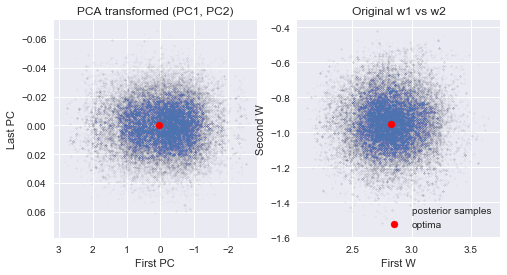

In [12]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("PCA transformed (PC1, PC2)")
plt.scatter(transfomred_weights[:,0], transfomred_weights[:,-1], s=3, alpha=0.01)
plt.scatter([transfomred_weights[0,0]], [transfomred_weights[0,-1]], color="red", label="optima")
plt.ylabel("Last PC")
plt.xlabel("First PC")
plt.xlim(max(transfomred_weights[:,0])*1.1, min(transfomred_weights[:,0])*1.1)
plt.ylim(max(transfomred_weights[:,-1])*1.1, min(transfomred_weights[:,-1])*1.1)

plt.subplot(1,2,2)
plt.title("Original w1 vs w2")
plt.scatter(PosteriorW[:,0], PosteriorW[:,1], s=3, alpha=0.01, label="posterior samples")
plt.scatter([W[0]],[W[1]], color="red", label="optima")
plt.xlabel("First W")
plt.ylabel("Second W")
plt.legend()
plt.show()

In [16]:
np.save("./RWMH-posteior", PosteriorW)

# Confirming the posterior distribution with STAN

Using PyStan to confirm that the posteior distribution we sampled with RWMH is in fact accurate.

In [33]:
model_code = """
data {
  int n;                                
  int m;
  matrix[n, m] A;
  vector[n] y;
}
parameters {
  vector[m] delta;
  real<lower=0> lambda;
}
model {
  for (i in 1:m) {
    delta[i] ~ normal(0, 1);
  }
  y ~ normal(A * delta, 1);
}
"""

In [34]:
data = {
    "n": wine_itr.X.shape[0],
    "m": wine_itr.d,
    "A": wine_itr.X,
    "y": wine_itr.Y[:,0]
}

In [35]:
fit = pystan.stan(model_code=model_code, data=data, iter=1500, warmup=500, chains=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d4b361529b1feb86f37bdc01786447 NOW.


In [36]:
fit

Inference for Stan model: anon_model_e1d4b361529b1feb86f37bdc01786447.
1 chains, each with iter=1500; warmup=500; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta[0]    1.32    0.02   0.28   0.75   1.13   1.32    1.5    1.9  346.0    1.0
delta[1]   -1.18  5.1e-3   0.15  -1.49  -1.28  -1.18  -1.07   -0.9  925.0    1.0
delta[2]    1.07  7.0e-3   0.22   0.65   0.93   1.07   1.21   1.53 1000.0    1.0
delta[3]    -3.3    0.04   0.62   -4.6  -3.69  -3.29  -2.87  -2.16  313.0    1.0
delta[4]    1.79  8.4e-3   0.24   1.32   1.62   1.79   1.95   2.25  802.0    1.0
delta[5]    3.11    0.01   0.31   2.52   2.91   3.11    3.3    3.7  836.0    1.0
delta[6]    0.32  7.4e-3   0.22  -0.11   0.17   0.31   0.47   0.73  876.0    1.0
delta[7]   14.57    0.07   1.19   12.3  13.76  14.56  15.37  16.97  298.0    1.0
delta[8]    1.49  8.2e-3   0.15   1.18   1.39   1.49    1.6   1.78  347.0    1.0
de

In [32]:
1/4.51

0.22172949002217296

In [15]:
results["STAN"] = fit.extract()["delta"]

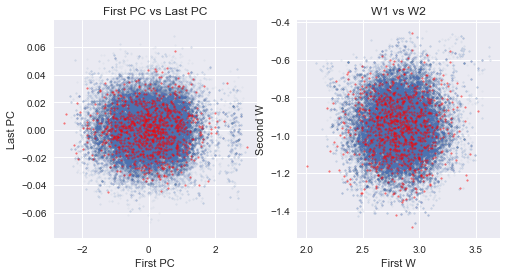

In [16]:
samples = results["RWMH"]
pca = PCA(n_components=11)
pcaed_samples = pca.fit_transform(samples)

samples2 = results["STAN"]
pca2 = PCA(n_components=11)
pcaed_samples2 = pca2.fit_transform(samples2)

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.title("First PC vs Last PC")
plt.scatter(pcaed_samples[:,0], pcaed_samples[:,-1], s=3, alpha=0.05, label="RWMH")
plt.scatter(pcaed_samples2[:,0], pcaed_samples2[:,-1], s=3, alpha=0.5, color="red", label="STAN")
plt.ylabel("Last PC")
plt.xlabel("First PC")

plt.subplot(1,2,2)
plt.title("W1 vs W2")
plt.scatter(samples[:,0], samples[:,1], s=3, alpha=0.05, label="RWMH")
plt.scatter(samples2[:,0], samples2[:,1], s=3, alpha=0.5, color="red", label="STAN")
plt.xlabel("First W")
plt.ylabel("Second W")
plt.show()

For the plot above, the red dots represnt samples generated by STAN and blue dots are samples gnerated by random walk metropolis hastings.

# Experiment 1 with online noise covariance update and constant learning rate.

This implements the case 1 in the paper, where you use a single universal learning rate for all weights. This is obviously going to results in a noise posterior, but we want to know how noise it is going to be on a simple model.  

Let's fisrt define a model and other optimization stuff.

In [11]:
D = wine_itr.d
N = wine_itr.n

In [12]:
# Input and output
# Use Placeholder in tf for input and output.
x_tf = tf.placeholder(tf.float64, [None, wine_itr.d])  # data matrix
y_tf = tf.placeholder(tf.float64, [None, 1]) # target matrix
learning_rate = tf.placeholder(tf.float64) # learning rate

# Single fully connected layer
# Loads in the noise + optimal weights calculated above as a starting point
W_tf = tf.Variable(W, name="weight") # weight matrix
dense = tf.matmul(x_tf, W_tf) # fully connected multiplication

In [13]:
cost = tf.reduce_mean(tf.square(tf.subtract(y_tf, dense)))/2.0+tf.reduce_sum(tf.square(W_tf))/N/2.0

In [14]:
optimizer_sgd = tf.train.GradientDescentOptimizer(learning_rate)
tvars = tf.trainable_variables()
gradients = optimizer_sgd.compute_gradients(cost, tvars)
train_op = optimizer_sgd.minimize(cost, var_list=tvars)

Now, we sample according to the algorithm. We spend first 2000 iterations for just learning the gradient covariance matrix.

In [20]:
sample_num = 10000 # this samples 10000-2000 samples
burnin = 2000 # this stabilizes the online estimation of noise covariance
batch_size = 100

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    w = sess.run([W_tf])
    epsilons = []
    samples =[]
    C = np.zeros((11,1))
    for s in range(sample_num):
        if s%2000 == 0:
            print "Collected", s, "samples"
            #print wine_itr.index

        # get a batch of samples
        xb, yb = wine_itr.next(batch_size)
        
        # get the batch wise stochastic gradient
        g_s = sess.run([gradients], feed_dict={x_tf: xb, y_tf: yb, learning_rate:1.0})[0]
        
        # get the gradient of the first sample in the batch
        g_1 = sess.run([gradients], feed_dict={x_tf: xb[0:1,], y_tf: yb[0:1,], learning_rate:1.0})[0]
        
        # calculating the learning rate
        temp = np.square(g_1[0][0]-g_s[0][0])
        k = 1.0/(s+1)
        C = (1-k)*C + k*temp
        epsilon = 2.0*batch_size/N*D/np.sum(C)
        epsilons.append(epsilon)
        
        # get cost and gradients and weights
        if s > burnin: 
            w, _ = sess.run([W_tf, train_op], feed_dict={x_tf: xb, y_tf: yb, learning_rate:epsilon})
            samples.append(w[:,0])
samples = np.array(samples)

Collected 0 samples
Collected 2000 samples
Collected 4000 samples
Collected 6000 samples
Collected 8000 samples


The estimated optimal learning rate seem to convege to a single value over some preiod of time.

last epsilon: 0.538380034801


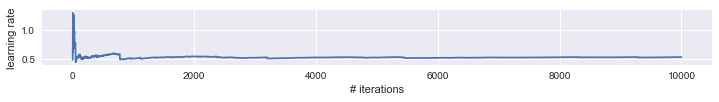

In [21]:
print "last epsilon:", epsilons[-1]
plt.figure(figsize=(12,1))
plt.plot(epsilons)
plt.ylabel("learning rate")
plt.xlabel("# iterations")
plt.show()

In [22]:
truth = results["RWMH"]
pca = PCA(n_components=11)
pcaed_truth = pca.fit_transform(truth)

pca = PCA(n_components=11)
pcaed_samples = pca.fit_transform(samples)

Down below, we have a plot of estimated posteior distribution with stochastic gradinet descent with the proposed learning rate. Green distriutiosn, which is esimated by the SGD method, is too sharp for almost all weights.

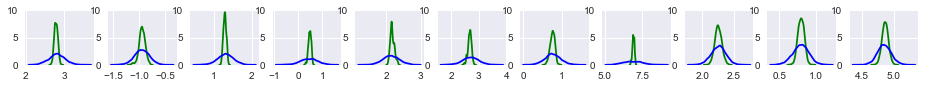

In [23]:
plt.figure(figsize=(16,1))
for i in range(D):
    plt.subplot(1,11,i+1)
    sns.distplot(samples[:,i], hist=False, color="green")
    sns.distplot(truth[:,i], hist=False, color="blue")
    plt.ylim(0,10)
plt.savefig("scalerLR.png")
plt.show()

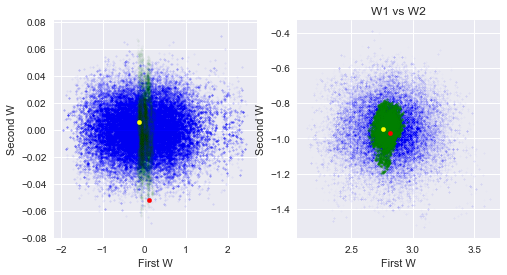

In [24]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(pcaed_truth[:,0], pcaed_truth[:,-1], s=3, alpha=0.05, color="blue", label="RWMH")
plt.scatter(pcaed_samples[:,0], pcaed_samples[:,-1], s=3, alpha=0.03, color="green", label="SGD")
plt.scatter([pcaed_samples[0,0]], [pcaed_samples[0,-1]], s=20, alpha=1, color="red", label="SGD")
plt.scatter([pcaed_samples[-1,0]], [pcaed_samples[-1,-1]], s=20, alpha=1, color="yellow", label="SGD")
plt.xlabel("First W")
plt.ylabel("Second W")  

plt.subplot(1,2,2)
plt.title("W1 vs W2")
plt.scatter(truth[:,0], truth[:,1], s=3, alpha=0.01, color="blue", label="RWMH")
plt.scatter(samples[:,0], samples[:,1], s=3, alpha=0.5, color="green", label="SGD")
plt.scatter([samples[0,0]], [samples[0,1]], s=20, alpha=1, color="red", label="SGD")
plt.scatter([samples[-1,0]], [samples[-1,1]], s=20, alpha=1, color="yellow", label="SGD")
plt.xlabel("First W")
plt.ylabel("Second W")
plt.show()

# Diagonal noise covariance estimation
Well that was kind of bad how about only using diagonal entries of preconditioning matrix?  
This should be better than a single learning rate.

In [12]:
D = wine_itr.d
N = wine_itr.n

In [13]:
# Input and output
# Use Placeholder in tf for input and output.
x_tf = tf.placeholder(tf.float64, [None, wine_itr.d])  # data matrix
y_tf = tf.placeholder(tf.float64, [None, 1]) # target matrix

# Single fully connected layer
# Loads in the noise + optimal weights calculated above as a starting point
W_tf = tf.Variable(W, name="weight") # weight matrix
dense = tf.matmul(x_tf, W_tf) # fully connected multiplication

In [14]:
cost = tf.reduce_mean(tf.square(tf.subtract(y_tf, dense)))/2.0+tf.reduce_sum(tf.square(W_tf))/N/2.0

In [15]:
# Optimization operations
# SGD of learning rate 1 is used because we can manually 
# multiply gradients with custom learning rate later.
optimizer_sgd = tf.train.GradientDescentOptimizer(1.0)

# Obtaining trainable weights
tvars = tf.trainable_variables()

# Calculate gradients with respect to trainable variables
sgd_gradients = optimizer_sgd.compute_gradients(cost, tvars)

# Learing rates holder. This is a tuple of placeholders that
# match the size of the parameters in the variable holders.
learning_rate_holders = tuple(tf.placeholder(tf.float64, g[0].shape) for g in sgd_gradients)

In [16]:
# Multiplying the gradients with custom learning rates for each weight
adjusted_sgd_gradients = [(tf.multiply(sgd_gradients[i][0], learning_rate_holders[i]),
                           sgd_gradients[i][1]) for i in range(len(sgd_gradients))]

In [17]:
# Apply gradients to the weights.
train_sgd = optimizer_sgd.apply_gradients(adjusted_sgd_gradients, name="minimize_cost")

Let us sample now. We do burnin again for 2000 iterations.

In [18]:
sample_num = 10000
burnin = 2000
batch_size = 100

init = tf.global_variables_initializer()


with tf.Session() as sess:
    sess.run(init)
    
    epsilons = []
    samples =[]
    C = np.zeros((11,1))
    for s in range(sample_num):
        if s%2000 == 0:
            print "Collected", s, "samples"
            #print wine_itr.index

        # get a batch of samples
        xb, yb = wine_itr.next(batch_size)
        
        # get the batch wise stochastic gradient
        g_s = sess.run([sgd_gradients], feed_dict={x_tf: xb, y_tf: yb})[0]
        
        # get the gradient of the first sample in the batch
        g_1 = sess.run([sgd_gradients], feed_dict={x_tf: xb[0:1,], y_tf: yb[0:1,]})[0]
        
        # calculating the learning rate
        temp = np.square(g_1[0][0]-g_s[0][0])
        k = 1.0/(s+1)
        C = (1-k)*C + k*temp
        epsilon = 2.0*batch_size/N/C
        epsilons.append(epsilon)
        
        # get cost and gradients and weights
        if s > burnin:
            w, _ = sess.run([W_tf, train_sgd], feed_dict={x_tf: xb, y_tf: yb, learning_rate_holders:[epsilon]})
            samples.append(w[:,0])
samples = np.array(samples)
epsilons = np.array(epsilons)[:,:,0]

Collected 0 samples
Collected 2000 samples
Collected 4000 samples
Collected 6000 samples
Collected 8000 samples


In [19]:
truth = results["RWMH"]
pca = PCA(n_components=11)
pcaed_truth = pca.fit_transform(truth)

pca = PCA(n_components=11)
pcaed_samples = pca.fit_transform(samples)

Here is the estimated posterior of all weights.  
We can see that the estimation is definitely better than a single learning rate case.  
However, some posteriors are much sharper than the actual ones.

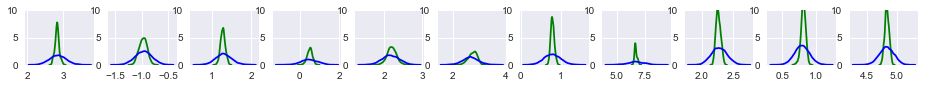

In [20]:
plt.figure(figsize=(16,1))
for i in range(D):
    plt.subplot(1,11,i+1)
    sns.distplot(samples[:,i], hist=False, color="green")
    sns.distplot(truth[:,i], hist=False, color="blue")
    plt.ylim(0,10)
plt.savefig("DiagonalLR.png")
plt.show()

Here is the 2d plot of first and second weight for convenience.

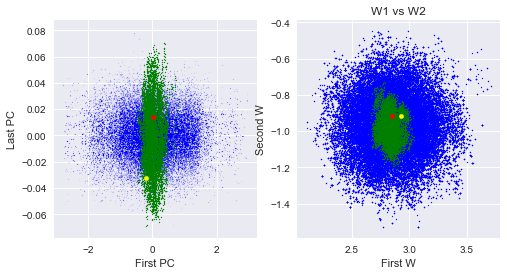

In [21]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(pcaed_truth[:,0], pcaed_truth[:,-1], s=1, alpha=0.05, color="blue", label="RWMH")
plt.scatter(pcaed_samples[:,0], pcaed_samples[:,-1], s=1, alpha=1, color="green", label="SGD")
plt.scatter([pcaed_samples[0,0]], [pcaed_samples[0,-1]], s=20, alpha=1, color="red", label="SGD")
plt.scatter([pcaed_samples[-1,0]], [pcaed_samples[-1,-1]], s=20, alpha=1, color="yellow", label="SGD")
plt.xlabel("First PC")
plt.ylabel("Last PC") 

plt.subplot(1,2,2)
plt.title("W1 vs W2")
plt.scatter(truth[:,0], truth[:,1], s=1, alpha=1, color="blue", label="RWMH")
plt.scatter(samples[:,0], samples[:,1], s=1, alpha=1, color="green", label="SGD")
plt.scatter([samples[0,0]], [samples[0,1]], s=20, alpha=1, color="red", label="SGD")
plt.scatter([samples[-1,0]], [samples[-1,1]], s=20, alpha=1, color="yellow", label="SGD")
plt.xlabel("First W")
plt.ylabel("Second W") 
plt.show()

We can also see that the weight converges.

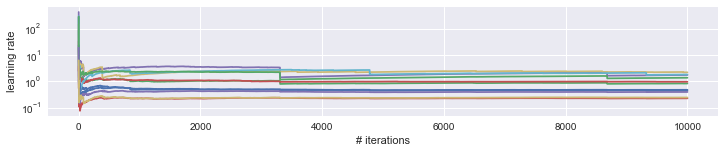

[ 0.47824606  0.8336693   0.96980915  1.76816521  2.23339061  1.84310507
  0.43957878  1.38520901  0.2257768   0.39387329  0.2430829 ]


In [22]:
plt.figure(figsize=(12,2))
for i in range(epsilons.shape[1]):
    plt.plot(epsilons[:, i])
plt.yscale("log")
plt.ylabel("learning rate")
plt.xlabel("# iterations")
plt.show()
print epsilons[-1]

# Posterior estimation with full-rank noise covariance.

Now, we finally use full-rank matrix to calculate learning rate (preconditioning matrix) for the SGD algorithm for estimating posterior distributions.

In [17]:
D = wine_itr.d
N = wine_itr.n

In [18]:
# Input and output
# Use Placeholder in tf for input and output.
x_tf = tf.placeholder(tf.float64, [None, wine_itr.d])  # data matrix
y_tf = tf.placeholder(tf.float64, [None, 1]) # target matrix

# Single fully connected layer
# Loads in the noise + optimal weights calculated above as a starting point
W_tf = tf.Variable(W, name="weight") # weight matrix
dense = tf.matmul(x_tf, W_tf) # fully connected multiplication

In [19]:
cost = tf.reduce_mean(tf.square(tf.subtract(y_tf, dense)))/2.0+tf.reduce_sum(tf.square(W_tf))/N/2.0#+10000

In [20]:
# Optimization operations
# SGD of learning rate 1 is used because we can manually 
# multiply gradients with custom learning rate later.
optimizer_sgd = tf.train.GradientDescentOptimizer(1.0)
# Calculate gradients with respect to trainable variables
tvars = tf.trainable_variables()
sgd_gradients = optimizer_sgd.compute_gradients(cost, tvars)

# Learing rates holder. This is a tuple of placeholders that
# match the size of the parameters in the variable holders.
precision_holders = tuple(tf.placeholder(tf.float64, [np.prod([i.value for i in g[0].shape]), np.prod([i.value for i in g[0].shape])]) for g in sgd_gradients)

In [21]:
sgd_steps = [(tf.matmul(precision_holders[i], sgd_gradients[i][0]),
                           sgd_gradients[i][1]) for i in range(len(sgd_gradients))]

In [22]:
train_full_covariance = optimizer_sgd.apply_gradients(sgd_steps, name="minimize_cost")

This time we only burnin for 1000 iterations.

In [23]:
sample_num = 5000
burnin = 1000
batch_size = 100
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    
    epsilons = []
    samples =[]
    C = np.zeros((11,11))
    for s in range(sample_num):
        if s%2000 == 0:
            print "Collected", s, "samples"
            #print wine_itr.index

        # get a batch of samples
        xb, yb = wine_itr.next(batch_size)
        
        # get the batch wise stochastic gradient
        g_s = sess.run([sgd_gradients], feed_dict={x_tf: xb, y_tf: yb})[0]
        
        # get the gradient of the first sample in the batch
        g_1 = sess.run([sgd_gradients], feed_dict={x_tf: xb[0:1,], y_tf: yb[0:1,]})[0]
        
        # calculating the learning rate
        temp = np.dot(g_1[0][0]-g_s[0][0], np.transpose(g_1[0][0]-g_s[0][0]))
        k = 1.0/(s+1)
        C = (1-k)*C + k*temp
        epsilon = 2.0*batch_size/N*np.linalg.inv(C)
        epsilons.append(epsilon)
        
        # get cost and gradients and weights
        if s > burnin:
            w, _ = sess.run([W_tf, train_full_covariance], feed_dict={x_tf: xb, y_tf: yb, precision_holders:[epsilon]})
            samples.append(w[:,0])
        
samples = np.array(samples)
epsilons = np.array(epsilons)[:,:,0]

Collected 0 samples
Collected 2000 samples
Collected 4000 samples


In [24]:
truth = results["RWMH"]
pca = PCA(n_components=11)
pcaed_truth = pca.fit_transform(truth)

pca = PCA(n_components=11)
pcaed_samples = pca.fit_transform(samples)

Here is the comparison of the estimated posterior distributions of weights by SGD (shown in blue) against that of random walk metropolis hastings (shown in green).  

The result looks phenomenal! However, this also shows that having the full preconditioning matrix is very importnat even in a small model with 11 weights. So this might not scale to bigger models such as convolutional neural nets.

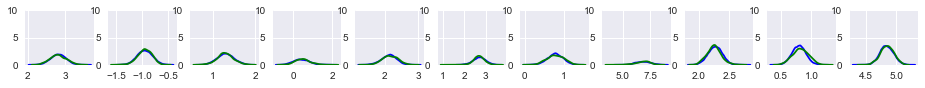

In [25]:
plt.figure(figsize=(16,1))
for i in range(D):
    plt.subplot(1,11,i+1)
    sns.distplot(truth[:,i], hist=False, color="blue")
    sns.distplot(samples[:,i], hist=False, color="green")
    plt.ylim(0,10)
plt.savefig("FullLR.png")
plt.show()

Here is the 2d plot for convenience.

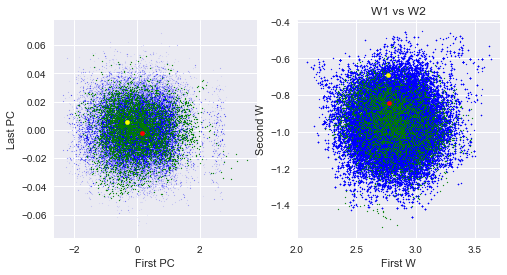

In [26]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(pcaed_truth[:,0], pcaed_truth[:,-1], s=1, alpha=0.05, color="blue", label="RWMH")
plt.scatter(pcaed_samples[:,0], pcaed_samples[:,-1], s=1, alpha=1, color="green", label="SGD")
plt.scatter([pcaed_samples[0,0]], [pcaed_samples[0,-1]], s=20, alpha=1, color="red", label="SGD")
plt.scatter([pcaed_samples[-1,0]], [pcaed_samples[-1,-1]], s=20, alpha=1, color="yellow", label="SGD")
plt.xlabel("First PC")
plt.ylabel("Last PC") 

plt.subplot(1,2,2)
plt.title("W1 vs W2")
plt.scatter(truth[:,0], truth[:,1], s=1, alpha=1, color="blue", label="RWMH")
plt.scatter(samples[:,0], samples[:,1], s=1, alpha=1, color="green", label="SGD")
plt.scatter([samples[0,0]], [samples[0,1]], s=20, alpha=1, color="red", label="SGD")
plt.scatter([samples[-1,0]], [samples[-1,1]], s=20, alpha=1, color="yellow", label="SGD")
plt.xlabel("First W")
plt.ylabel("Second W") 

plt.savefig("nicefigure.png")
plt.show()

# Attempting hyperparmeter estimations...
This is my attempt to estimate hyperparmeter estimation using variational expected maximization.  
I should do it in a separate notebook because this is becomeing too much.  
Currently the value shoots to negative inifinity. I need to redo this.  

In [13]:
# Lamlbda
lambda_tf = tf.Variable(1.0, dtype=tf.float64, name="hyperparameter")

In [14]:
# Cost
cost = tf.reduce_mean(tf.square(tf.subtract(y_tf, dense)))/2.0\
        +tf.reduce_sum(tf.square(W_tf))/N/2.0\
        -tf.log(1.0/tf.sqrt(tf.constant(2*3.14159, dtype=tf.float64)*lambda_tf))

In [15]:
# Optimization operations
# SGD of learning rate 1 is used because we can manually 
# multiply gradients with custom learning rate later.
optimizer_sgd = tf.train.GradientDescentOptimizer(1.0)
# Calculate gradients with respect to trainable variables
tvars = tf.trainable_variables()

# separating parameters
params = [t for t in tvars if t.name[0]!="h"]
hparams = [t for t in tvars if t.name[0]=="h"]

# gradients for parameters and hyper-parameters
gradients_params = optimizer_sgd.compute_gradients(cost, params)
gradients_hparams = optimizer_sgd.compute_gradients(cost, hparams)

In [16]:
# holding full-rank preconditioning matrix.
precision_holders = tuple(tf.placeholder(tf.float64,\
                    [np.prod([i.value for i in g[0].shape]), np.prod([i.value for i in g[0].shape])])\
                    for g in gradients_params)

In [17]:
hparams_steps = [(learning_rate*gradients_hparams[i][0],
                           gradients_hparams[i][1]) for i in range(len(gradients_hparams))]

train_hparams = optimizer_sgd.apply_gradients(hparams_steps)

In [18]:
# calculating the sgd step
sgd_steps = [(tf.matmul(precision_holders[i], gradients_params[i][0]),
                           gradients_params[i][1]) for i in range(len(gradients_params))]

In [19]:
train_full_covariance = optimizer_sgd.apply_gradients(sgd_steps, name="minimize_cost")

In [ ]:
sample_num = 5000
burnin = 1000
batch_size = 100

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    epsilons = []
    samples =[]
    C = np.zeros((11,11))
    for s in range(sample_num):
        if s%2000 == 0:
            print "Collected", s, "samples"
            #print wine_itr.index

        # get a batch of samples
        xb, yb = wine_itr.next(batch_size)
        
        # get the batch wise stochastic gradient
        g_s = sess.run([gradients_params], feed_dict={x_tf: xb, y_tf: yb, lambda_tf:1.0})[0]
        
        # get the gradient of the first sample in the batch
        g_1 = sess.run([gradients_params], feed_dict={x_tf: xb[0:1,], y_tf: yb[0:1,], lambda_tf:1.0})[0]
        
        # calculating the learning rate
        temp = np.dot(g_1[0][0]-g_s[0][0], np.transpose(g_1[0][0]-g_s[0][0]))
        k = 1.0/(s+1)
        C = (1-k)*C + k*temp
        epsilon = 2.0*batch_size/N*np.linalg.inv(C)
        epsilons.append(epsilon)
        
        
        # get cost and gradients and weights
        if s > burnin:
            w, _ = sess.run([W_tf, train_full_covariance], feed_dict={x_tf: xb, y_tf: yb, precision_holders:[epsilon], lambda_tf:1.0})
            samples.append(w[:,0])
            _, g = sess.run([train_hparams, gradients_hparams], feed_dict={x_tf: xb, y_tf: yb, learning_rate:0.01})
            print g
            print sess.run([lambda_tf])
        
samples = np.array(samples)
epsilons = np.array(epsilons)[:,:,0]